In [ ]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import shutil
import posixpath
import csv
import scipy.signal  as sgn
import os
from scipy import interpolate
from tqdm import tqdm
import pickle

import wfdb
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install wfdb

In [ ]:
import pickle
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

import biosppy.signals.tools as st
import numpy as np
import os
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
from scipy.signal import medfilt
from sklearn.utils import cpu_count
from tqdm import tqdm

# PhysioNet Apnea-ECG dataset
# url: https://physionet.org/physiobank/database/apnea-ecg/
base_dir = "dataset"

fs = 100
sample = fs * 60  # 1 min's sample points

before = 2  # forward interval (min)
after = 2  # backward interval (min)
hr_min = 20
hr_max = 300

num_worker = 35 if cpu_count() > 35 else cpu_count() - 1  # Setting according to the number of CPU cores


def worker(name, labels):
    X = []
    y = []
    groups = []
    signals = wfdb.rdrecord(os.path.join(base_dir, name), channels=[0]).p_signal[:, 0]
    for j in tqdm(range(len(labels)), desc=name, file=sys.stdout):
        if j < before or \
                (j + 1 + after) > len(signals) / float(sample):
            continue
        signal = signals[int((j - before) * sample):int((j + 1 + after) * sample)]
        signal, _, _ = st.filter_signal(signal, ftype='FIR', band='bandpass', order=int(0.3 * fs),
                                        frequency=[3, 45], sampling_rate=fs)
        # Find R peaks
        rpeaks, = hamilton_segmenter(signal, sampling_rate=fs)
        rpeaks, = correct_rpeaks(signal, rpeaks=rpeaks, sampling_rate=fs, tol=0.1)
        if len(rpeaks) / (1 + after + before) < 40 or \
                len(rpeaks) / (1 + after + before) > 200:  # Remove abnormal R peaks signal
            continue
        # Extract RRI, Ampl signal
        rri_tm, rri_signal = rpeaks[1:] / float(fs), np.diff(rpeaks) / float(fs)
        rri_signal = medfilt(rri_signal, kernel_size=3)
        ampl_tm, ampl_siganl = rpeaks / float(fs), signal[rpeaks]
        hr = 60 / rri_signal
        # Remove physiologically impossible HR signal
        if np.all(np.logical_and(hr >= hr_min, hr <= hr_max)):
            # Save extracted signal
            X.append([(rri_tm, rri_signal), (ampl_tm, ampl_siganl)])
            y.append(0. if labels[j] == 'N' else 1.)
            groups.append(name)
    return X, y, groups


if __name__ == "__main__":
    apnea_ecg = {}

    names = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

    o_train = []
    y_train = []
    groups_train = []
    print('Training...')
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = wfdb.rdann(os.path.join(base_dir, names[i]), extension="apn").symbol
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_train.extend(X)
            y_train.extend(y)
            groups_train.extend(groups)

    print()

    answers = {}
    with open(os.path.join(base_dir, "event-2-answers"), "r") as f:
        for answer in f.read().split("\n\n"):
            answers[answer[:3]] = list("".join(answer.split()[2::2]))

    names = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    o_test = []
    y_test = []
    groups_test = []
    print("Testing...")
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = answers[names[i]]
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_test.extend(X)
            y_test.extend(y)
            groups_test.extend(groups)

    apnea_ecg = dict(o_train=o_train, y_train=y_train, groups_train=groups_train, o_test=o_test, y_test=y_test,
                     groups_test=groups_test)
    with open(os.path.join(base_dir, "apnea-ecg.pkl"), "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("\nok!")

ModuleNotFoundError: ignored

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
import shutil
import posixpath
import csv
import scipy.signal  as sgn
import os

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0'

for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith('.dat'):
            record_name = os.path.splitext(filename)[0]  # 파일명에서 확장자 제거
            print(record_name)
            record = wfdb.rdrecord(os.path.join(dirname, record_name))

b01r
x27
b03
c08
c09
c04
x25
c02
x06
a10
a09
a13
x03
x19
x07
c03r
c01
c03
x08
a02r
x10
x20
a17
a11
x23
c01r
x01
x24
c07
a01r
x33
b01
x29
b02
a07
x31
x30
a14
a12
x11
a01
x28
x13
c02r
x15
x04
a02
x09
x18
x12
x32
x16
x17
x05
x02
x26
c10
x22
a16
c05
a20
a04
c06
b05
a19
a03
b04
a08
x21
x35
x14
x34
a04r
a03r
a06
a18
a05
a15


In [ ]:
directory_path = '/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0'

# 디렉토리 내의 파일 목록 가져오기
file_list = os.listdir(directory_path)

# 파일 목록을 데이터프레임으로 변환
ecgs_df = pd.DataFrame(file_list, columns=['id'])

# 파일 경로 열 추가
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: os.path.join(directory_path, x))

# 데이터셋 분할
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

# 결과 확인
print(ecgs_df)

            id                                           filepath dataset
0      a11.xws  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
1      x14.hea  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
2    b01er.apn  /content/drive/MyDrive/Colab Notebooks/apnea-e...   train
3      a09.xws  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
4      a20.qrs  /content/drive/MyDrive/Colab Notebooks/apnea-e...   train
..         ...                                                ...     ...
409    x31.apn  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
410    x32.apn  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
411    x33.apn  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
412    x34.apn  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test
413    x35.apn  /content/drive/MyDrive/Colab Notebooks/apnea-e...    test

[414 rows x 3 columns]


In [ ]:
ecgs_df

,id,filepath,dataset
0,a11.xws,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test
1,x14.hea,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test
2,b01er.apn,/content/drive/MyDrive/Colab Notebooks/apnea-e...,train
3,a09.xws,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test
4,a20.qrs,/content/drive/MyDrive/Colab Notebooks/apnea-e...,train
...,...,...,...
409,x31.apn,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test
410,x32.apn,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test
411,x33.apn,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test
412,x34.apn,/content/drive/MyDrive/Colab Notebooks/apnea-e...,test


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import wfdb
from IPython.display import display
import matplotlib.pyplot as plt
import shutil
import posixpath
import csv
import scipy.signal  as sgn
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [ ]:
# get the list of files to be processed
ecgs_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/list', header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0' + x) )
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [ ]:
freq = ecgs_df['dataset'].value_counts()
print(freq)

train    35
test     35
Name: dataset, dtype: int64


In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/apnea-ecg-database-1.0.0'):
   for filename in filenames:
       record = os.path.join(dirname, filename)
       wfdb.plot_wfdb(record, title='Record a01 from Physionet Kaggle Apnea ECG')
       display(record.__dict__)

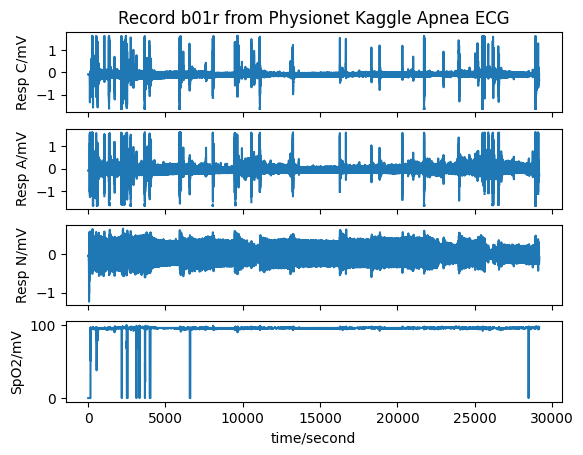

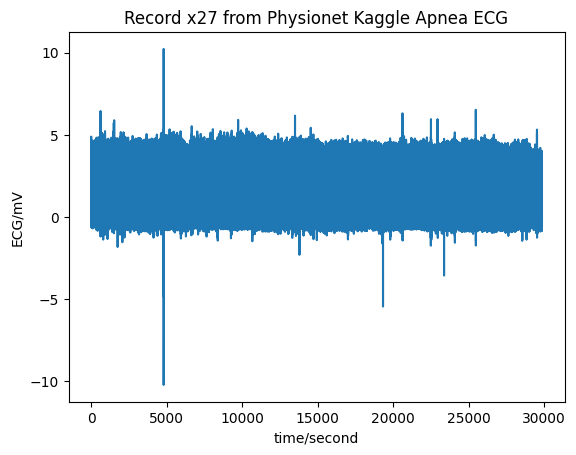

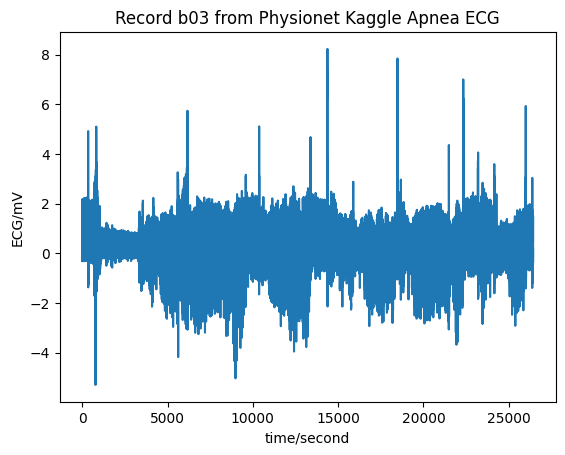

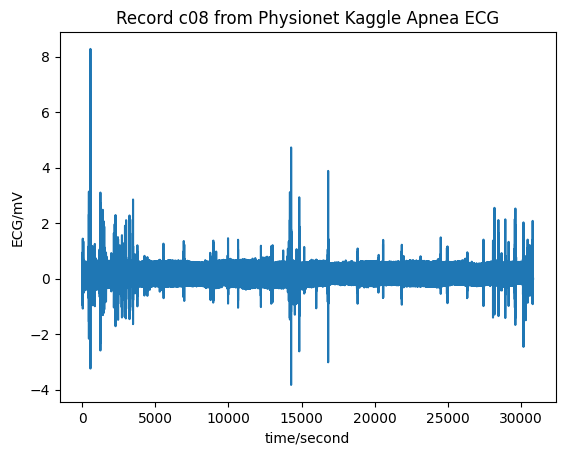

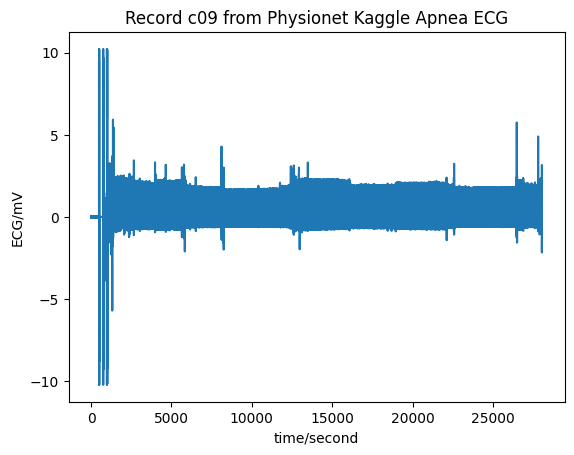

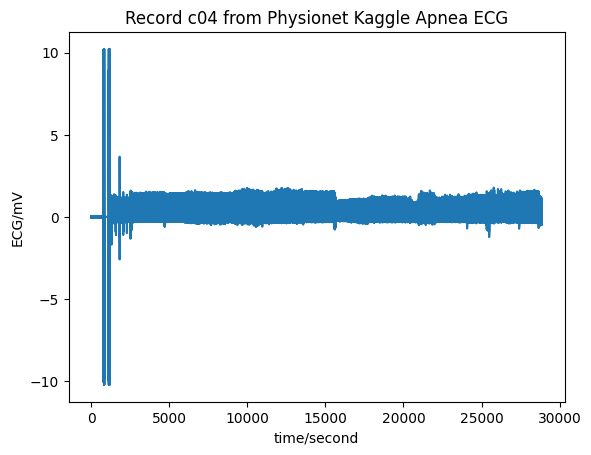

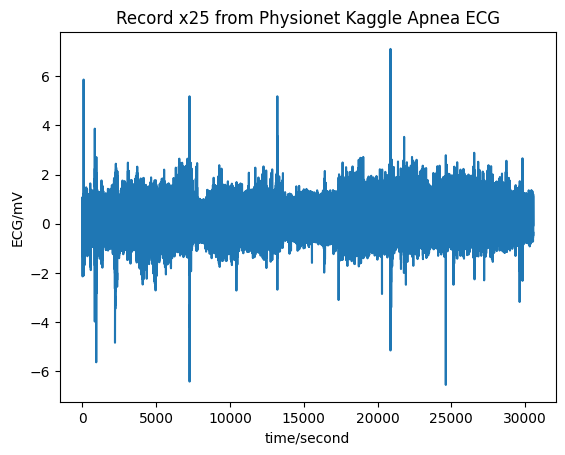

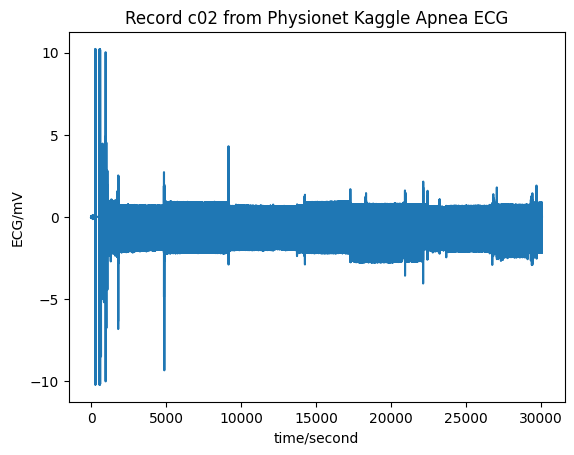

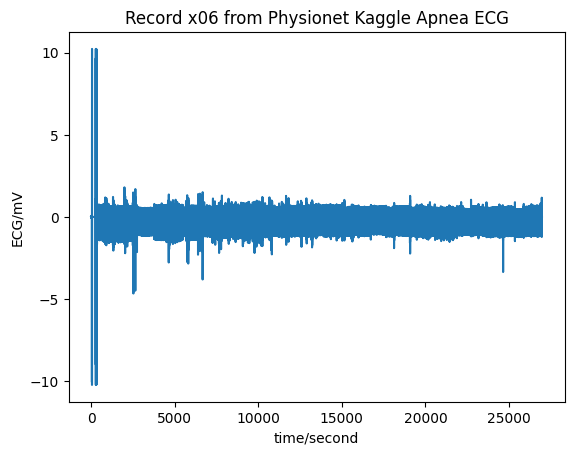

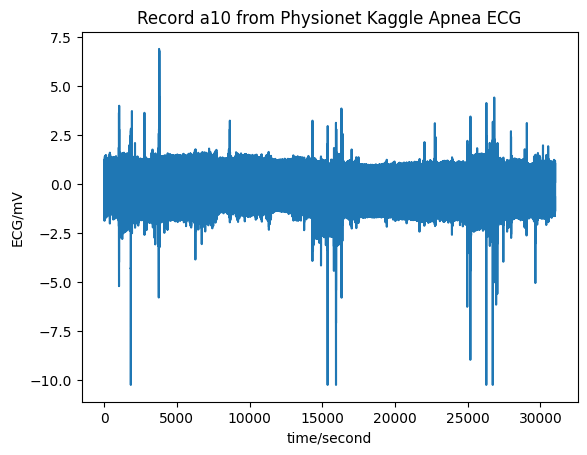

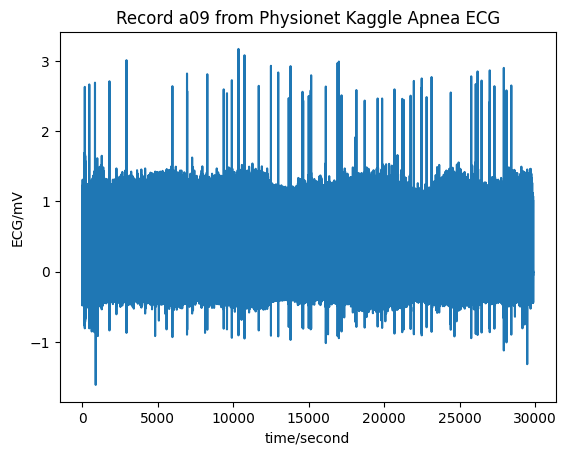

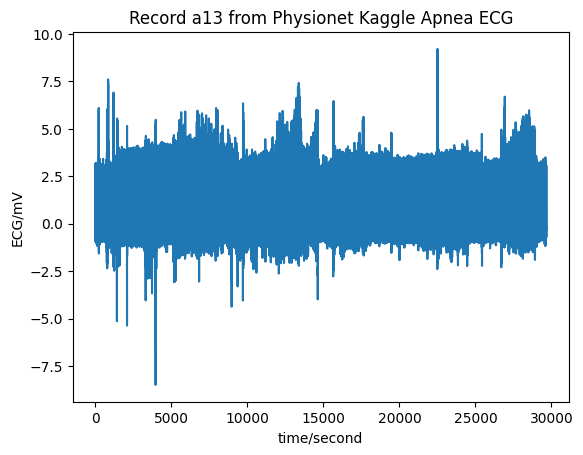

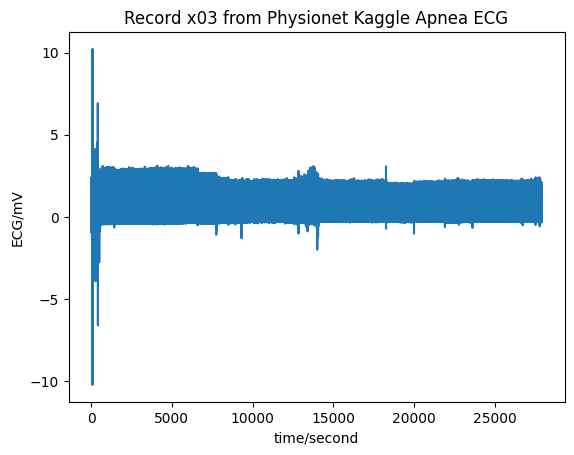

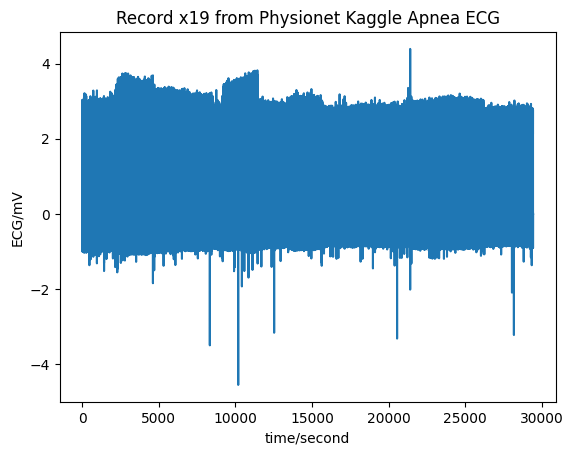

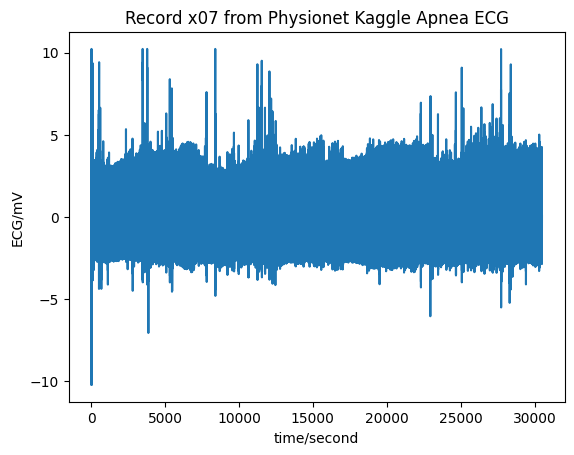

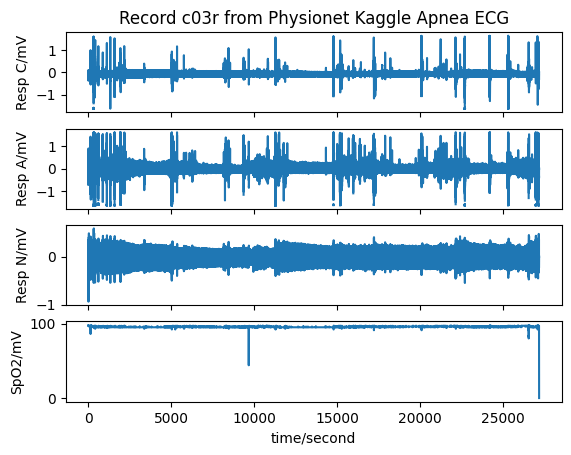

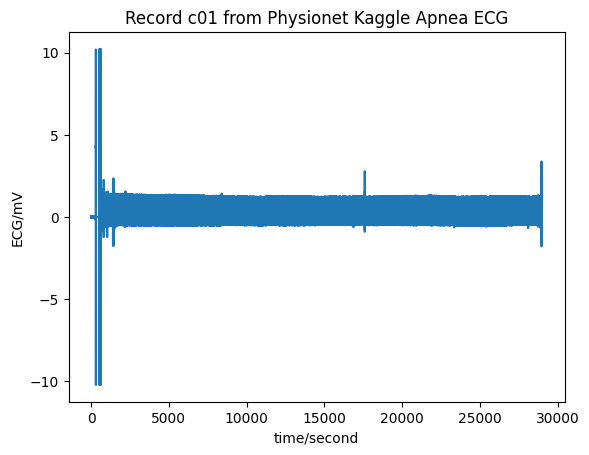

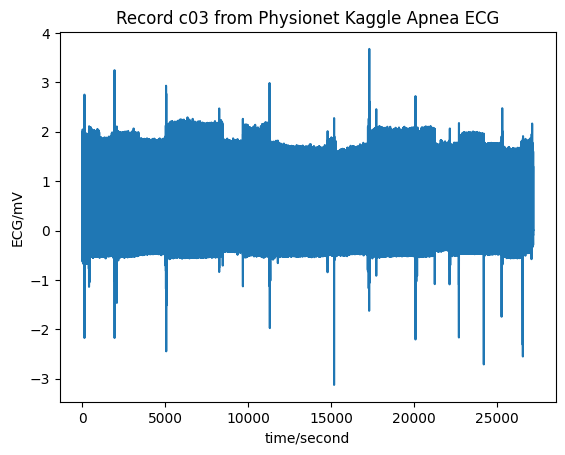

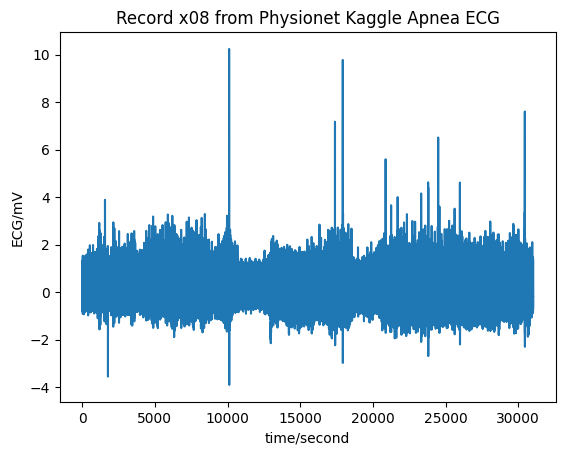

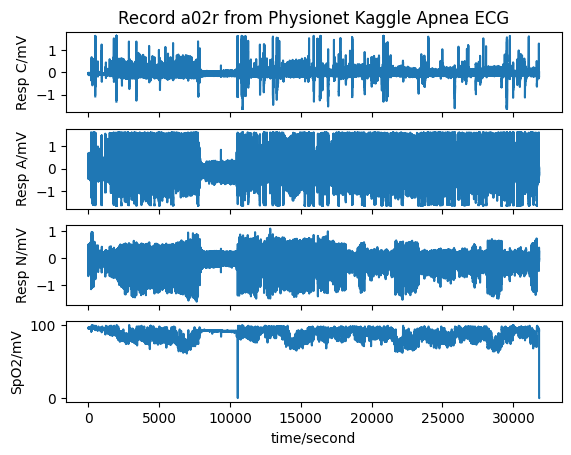

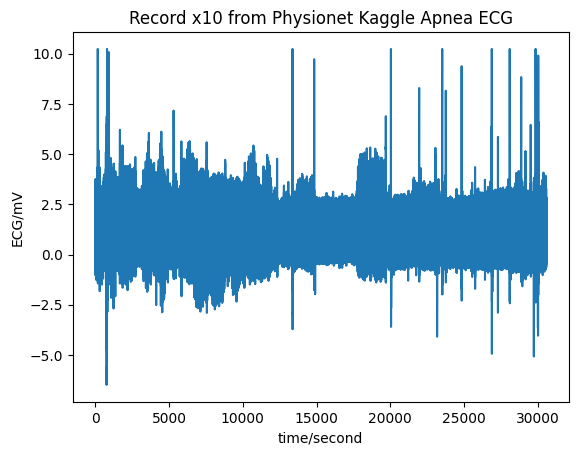

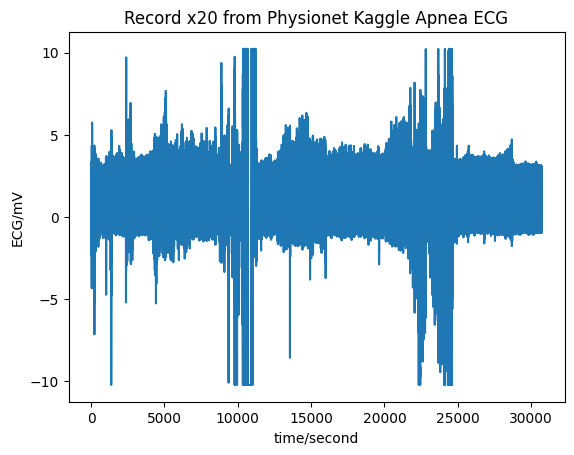

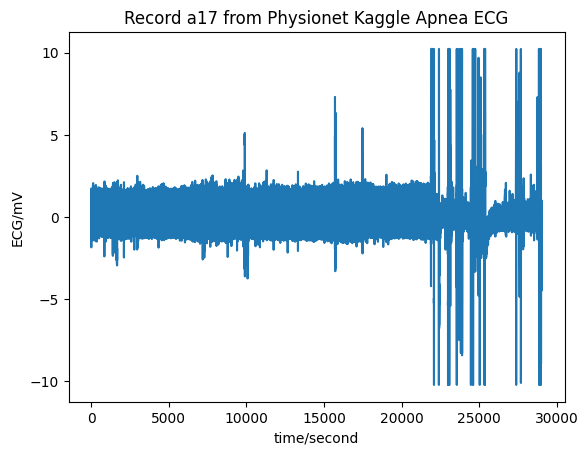

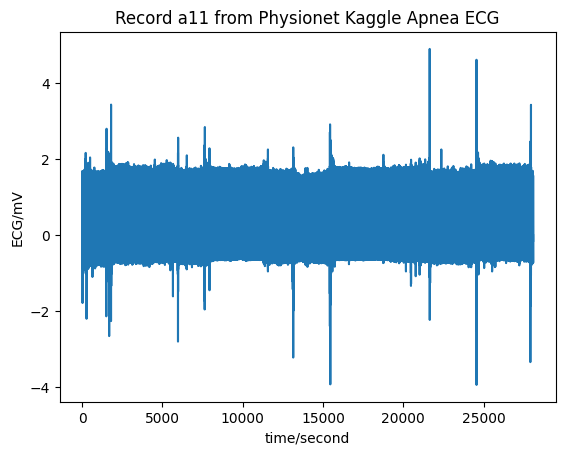

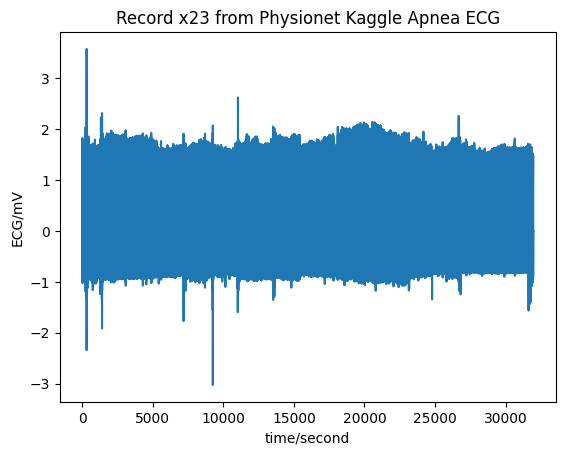

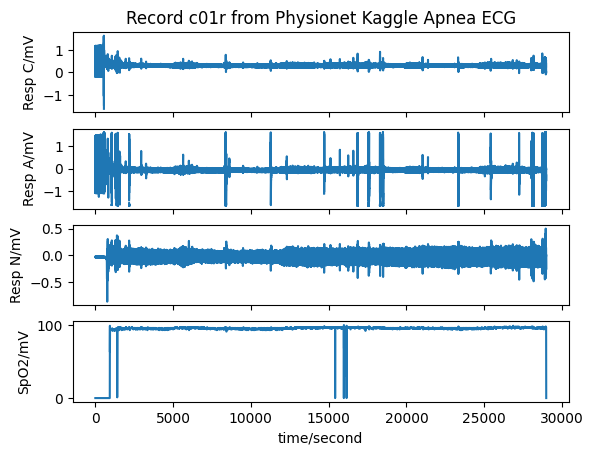

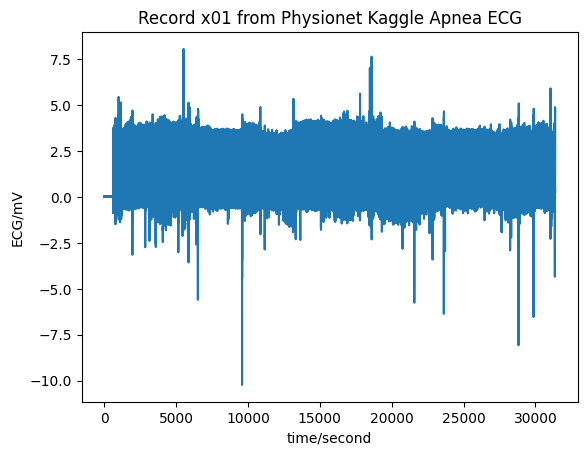

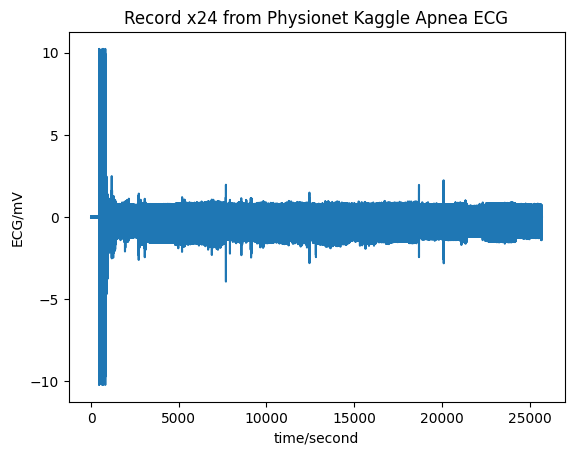

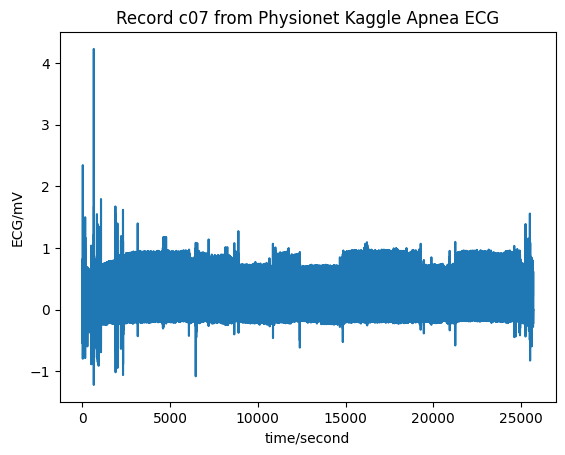

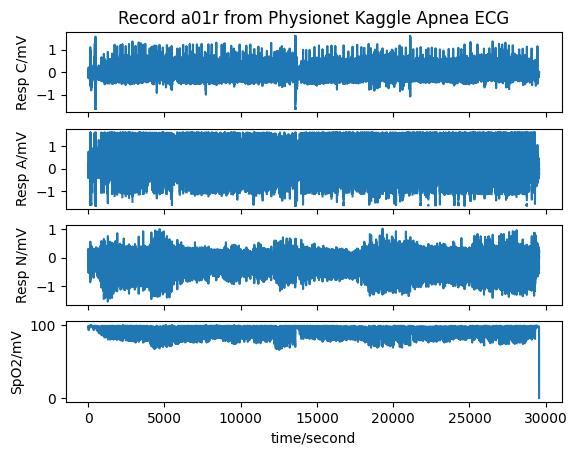

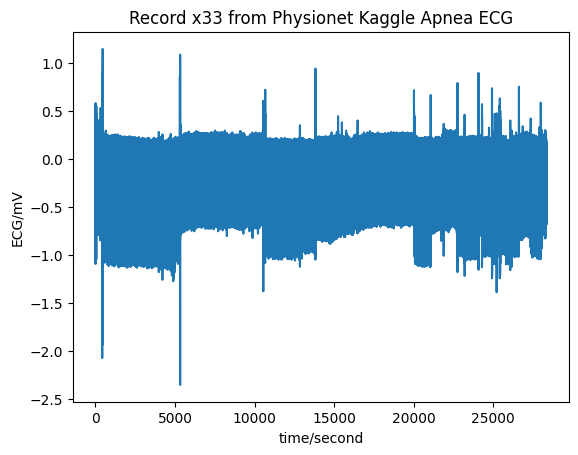

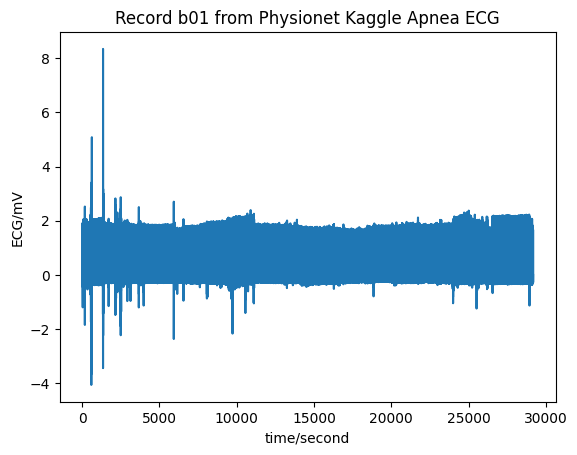

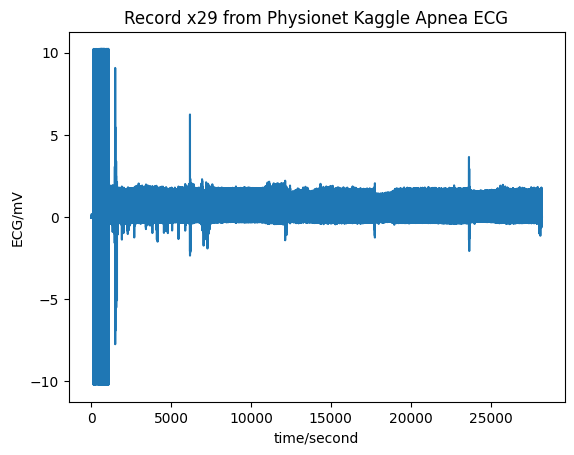

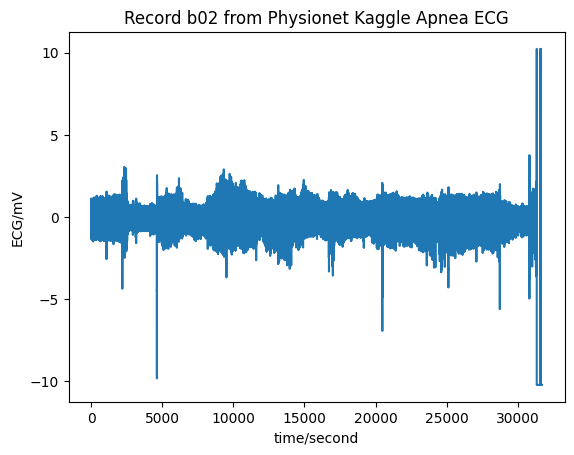

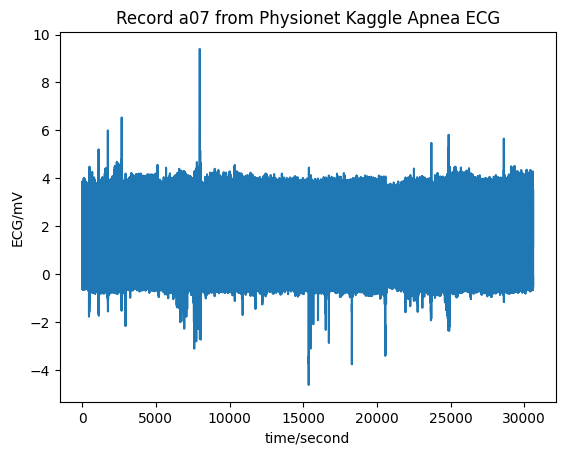

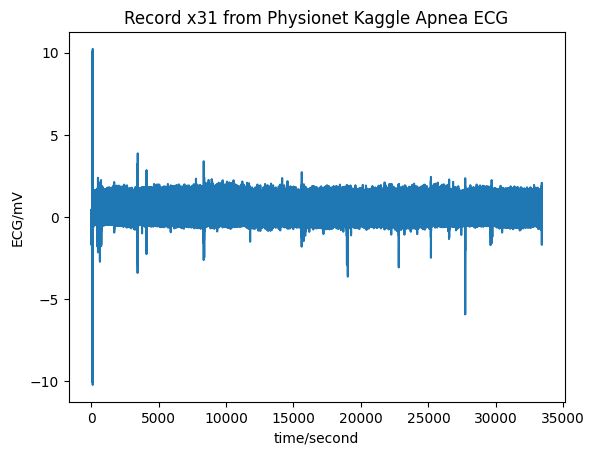

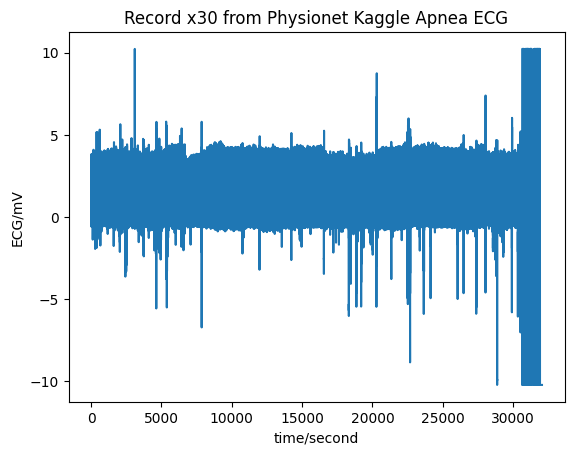

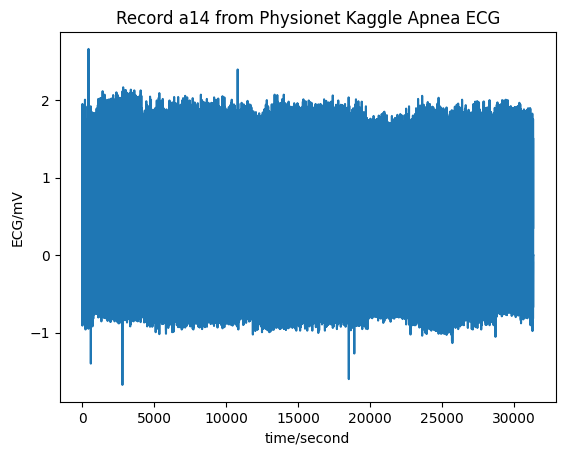

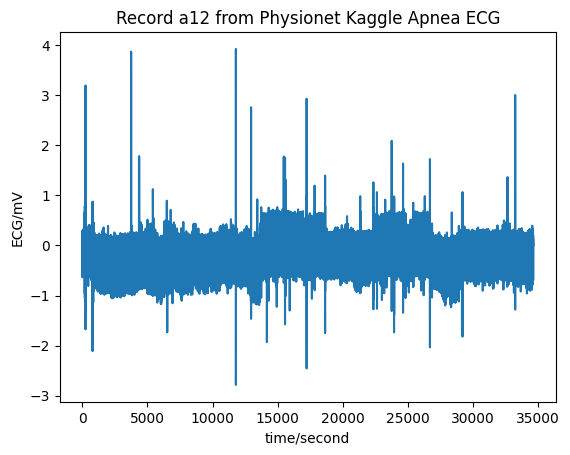

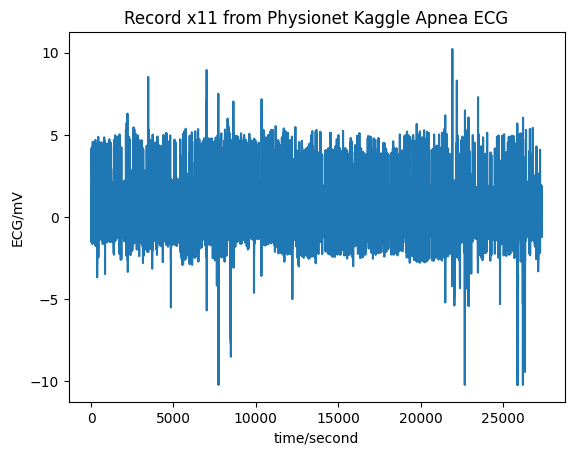

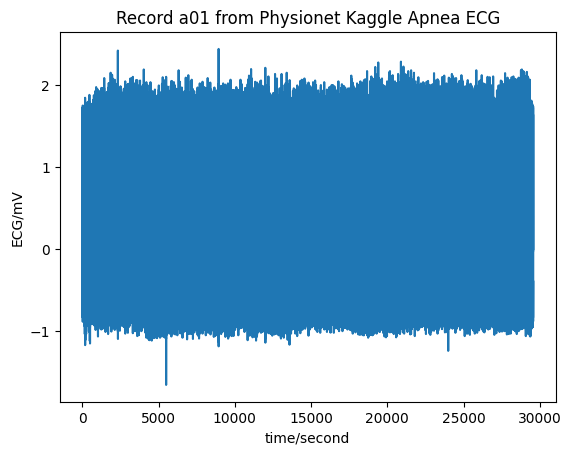

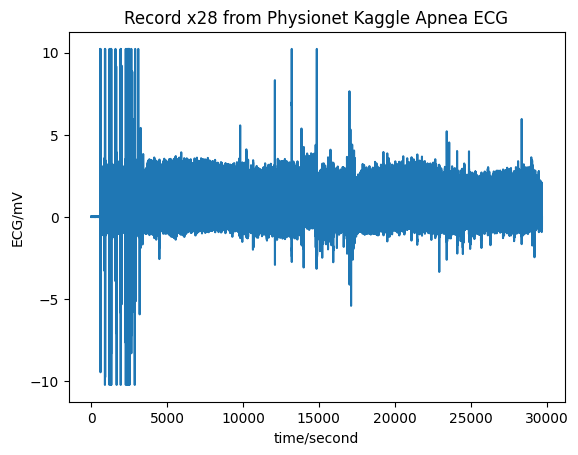

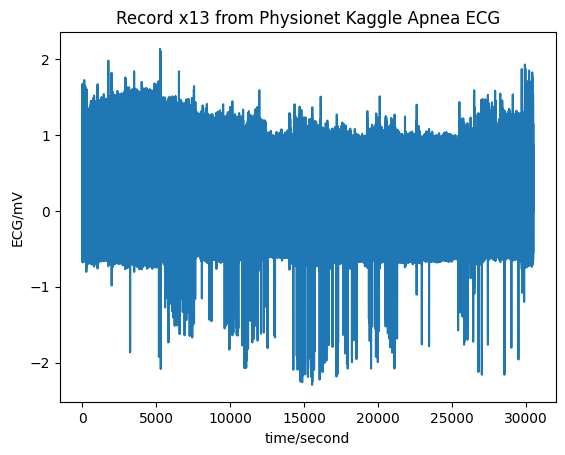

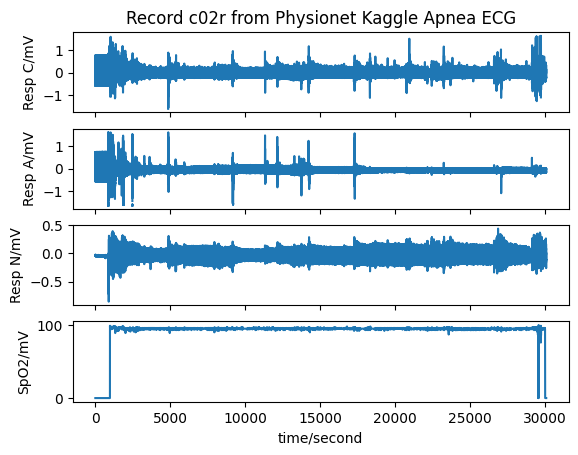

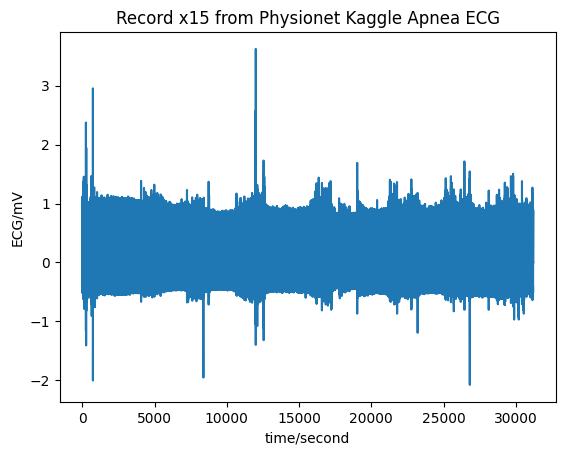

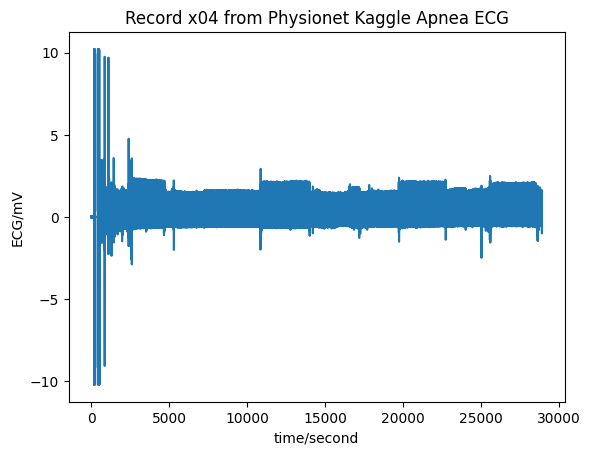

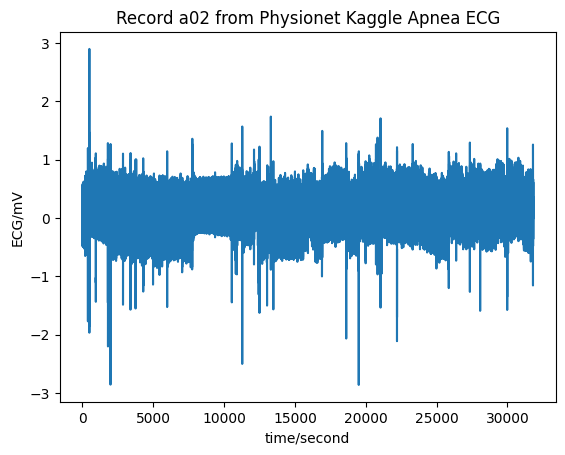

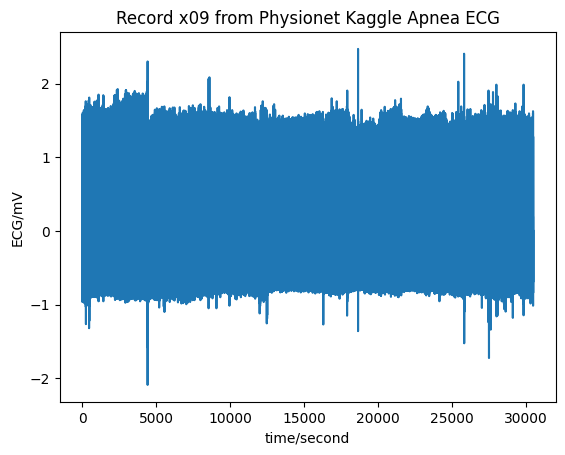

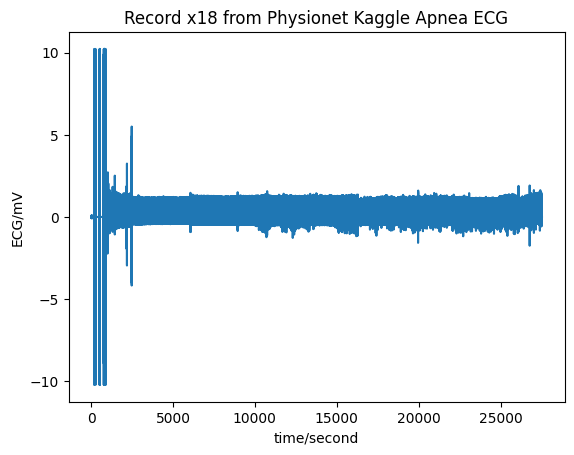

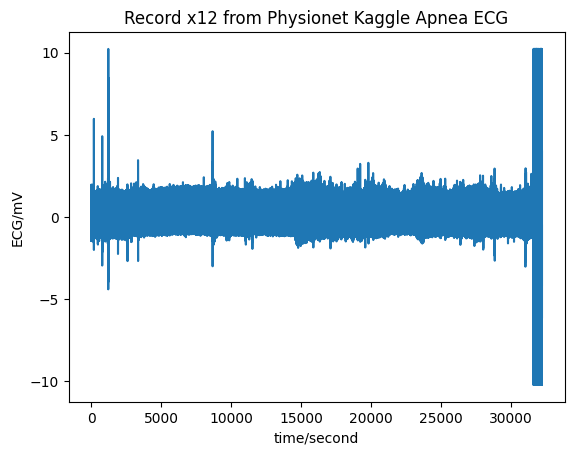

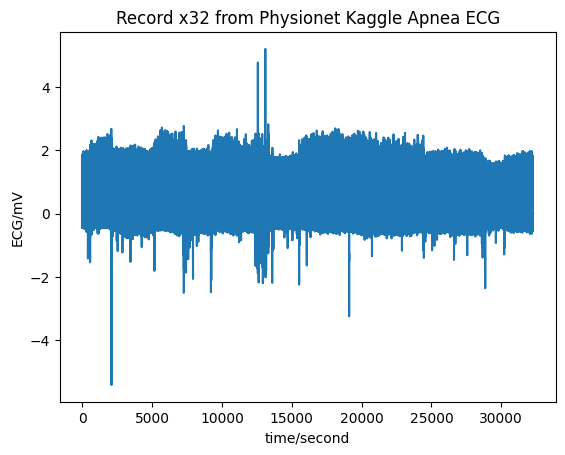

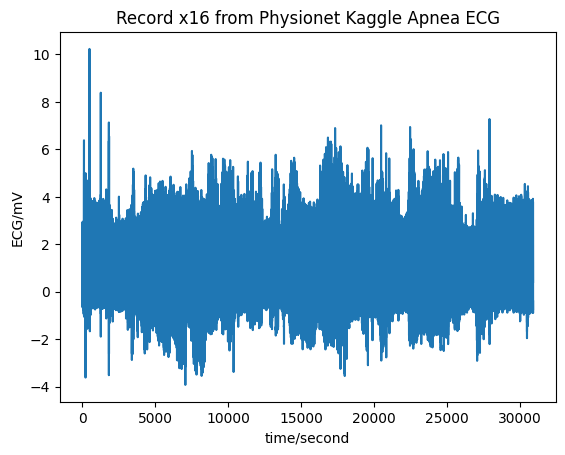

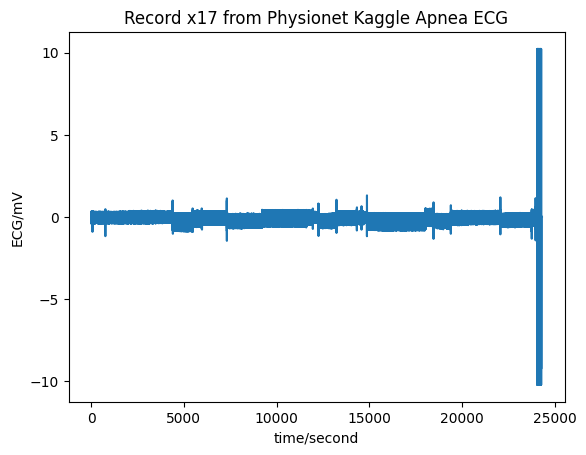

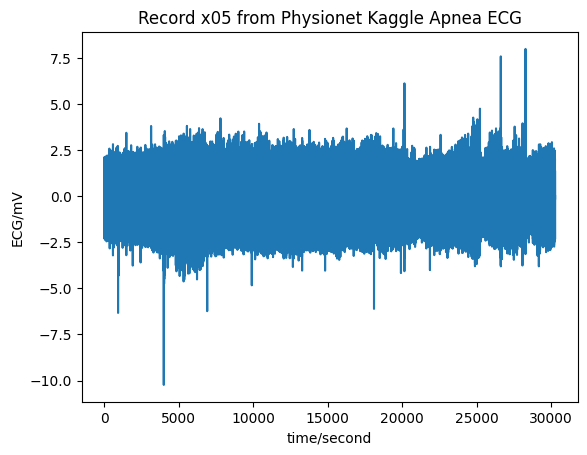

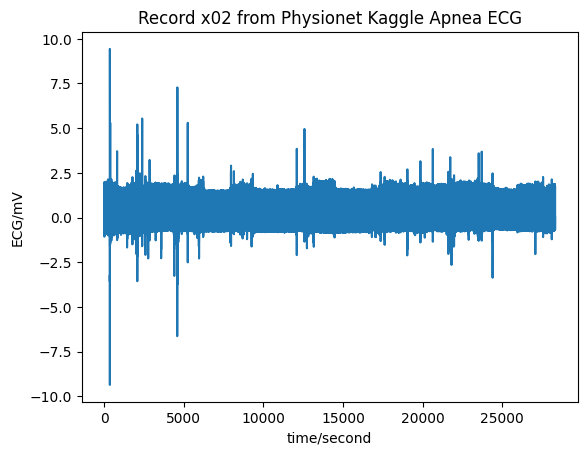

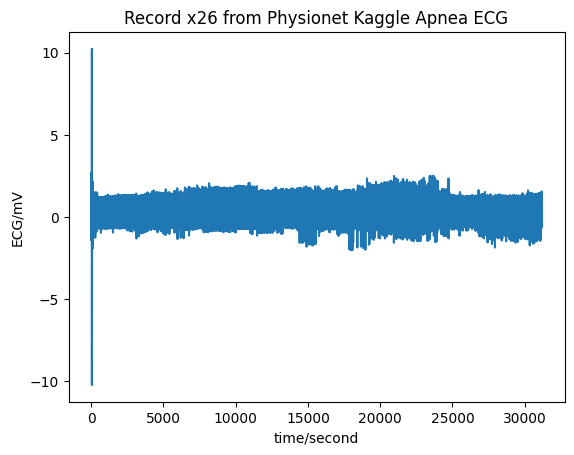

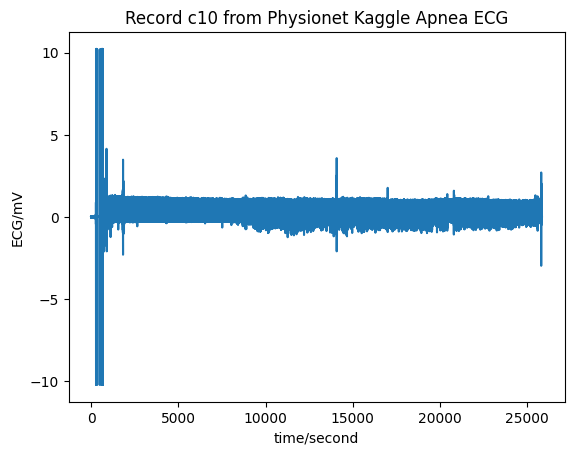

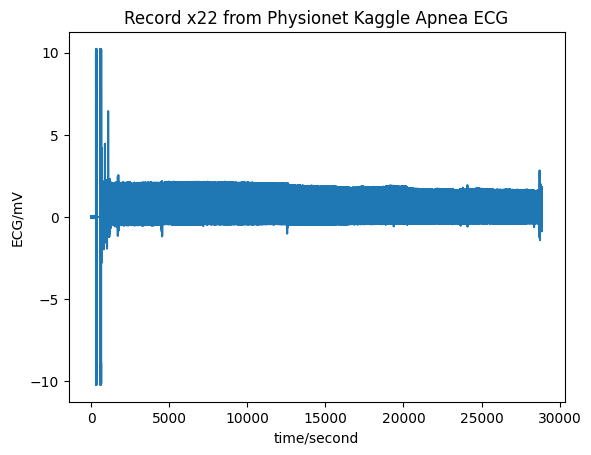

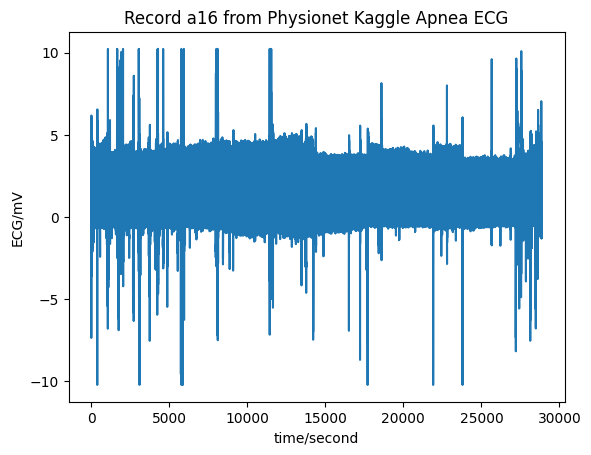

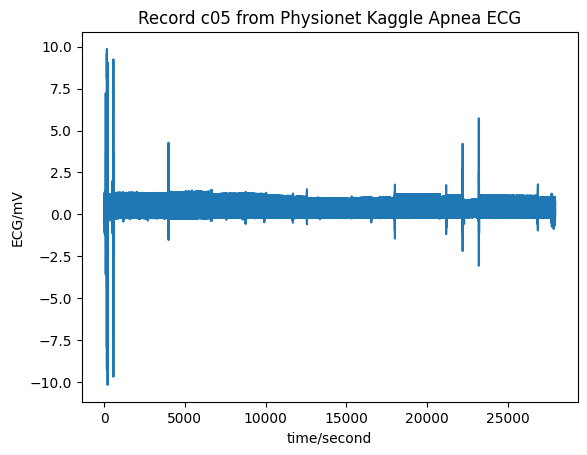

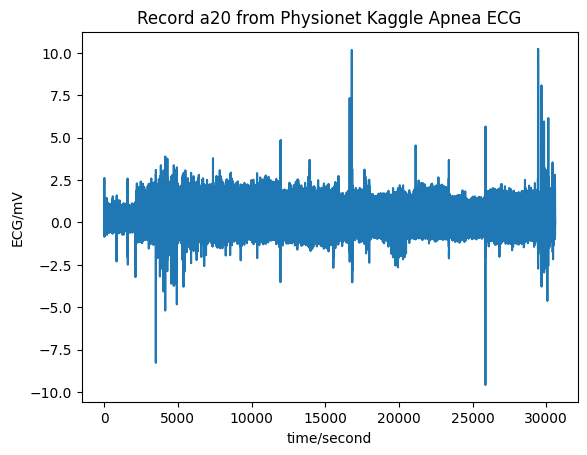

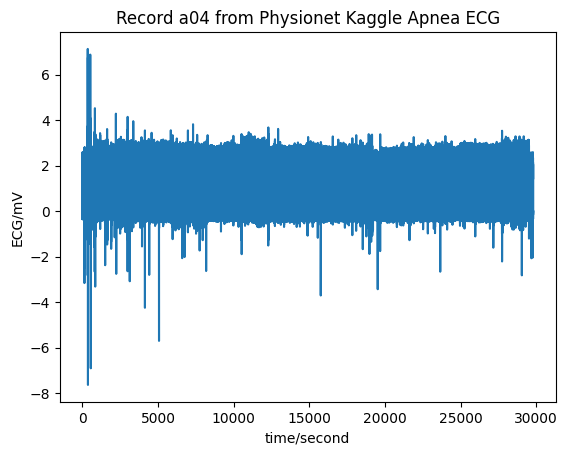

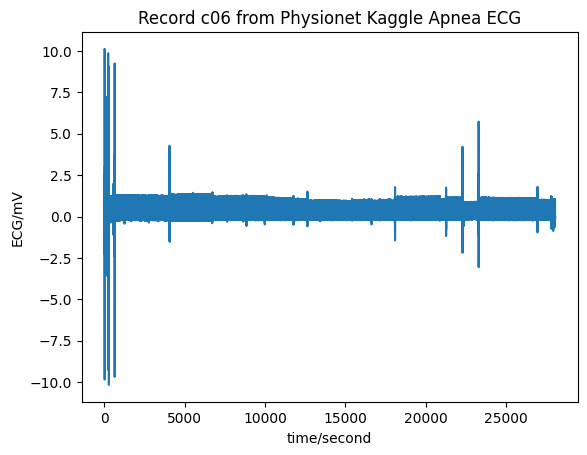

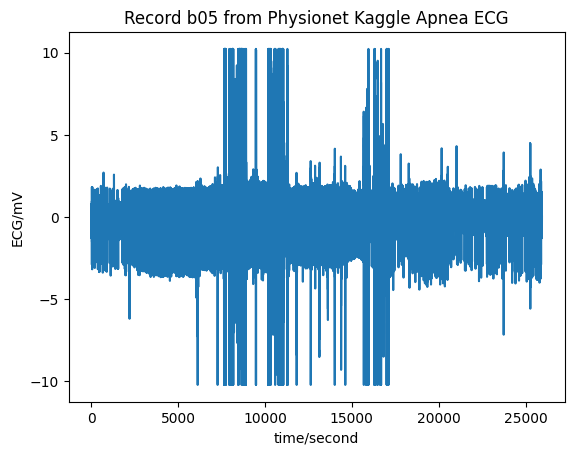

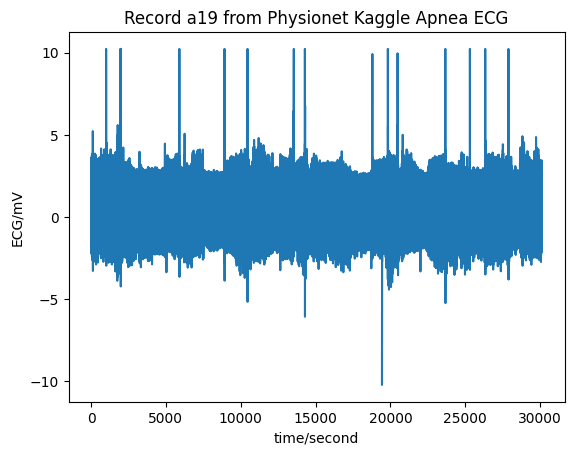

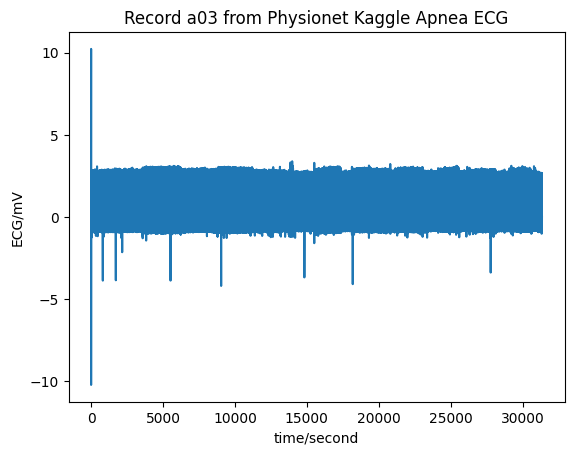

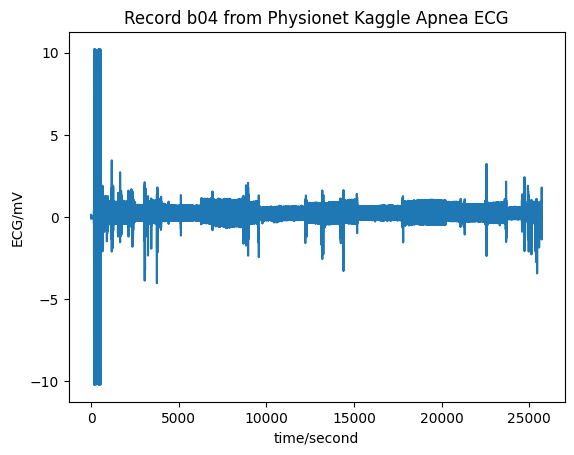

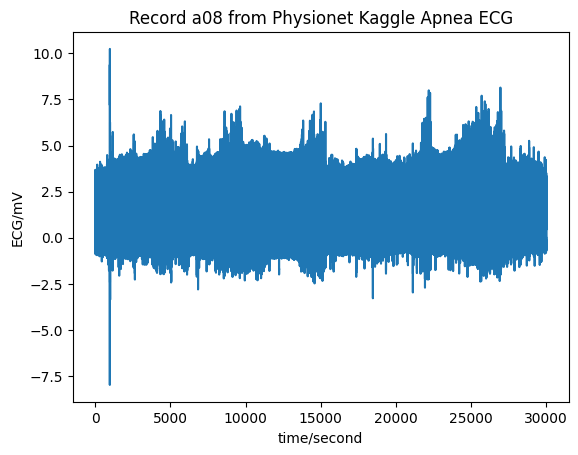

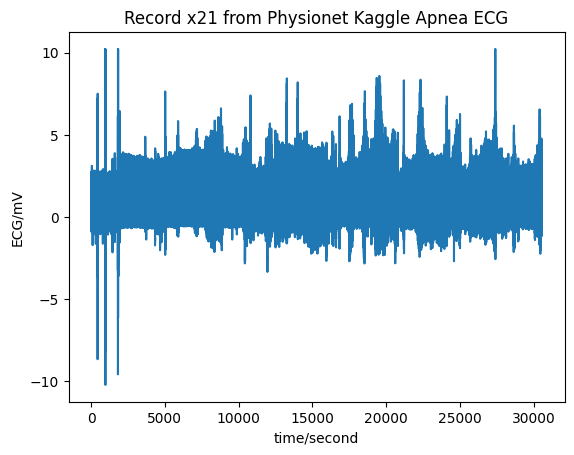

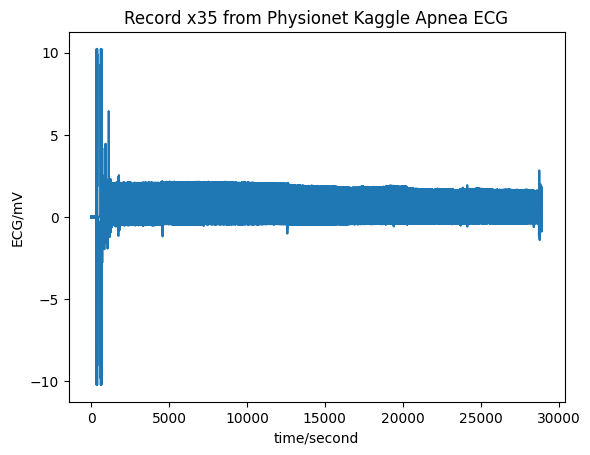

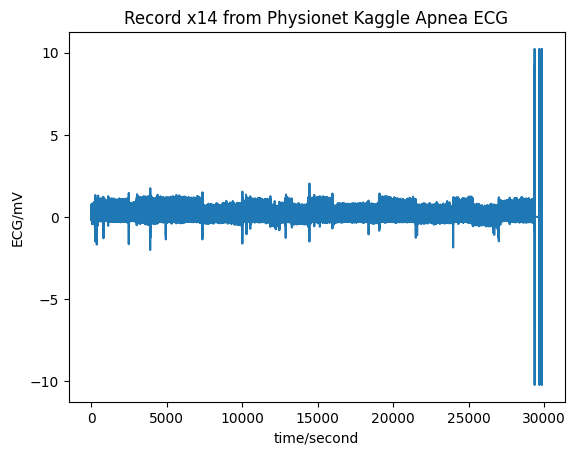

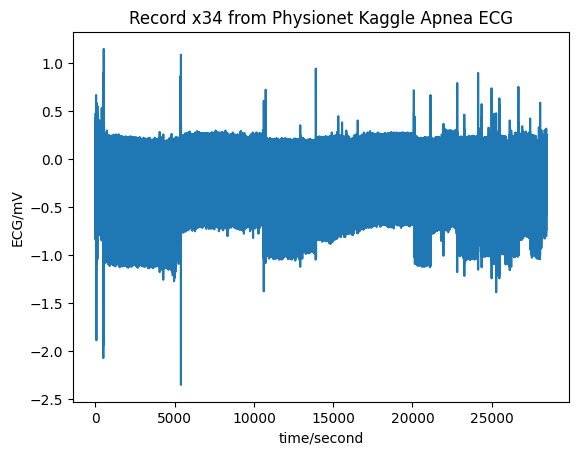

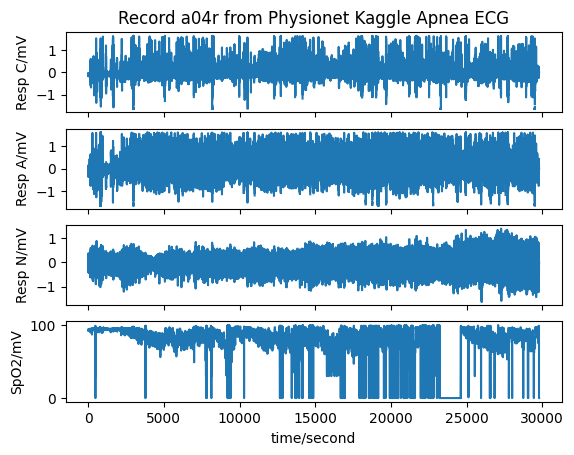

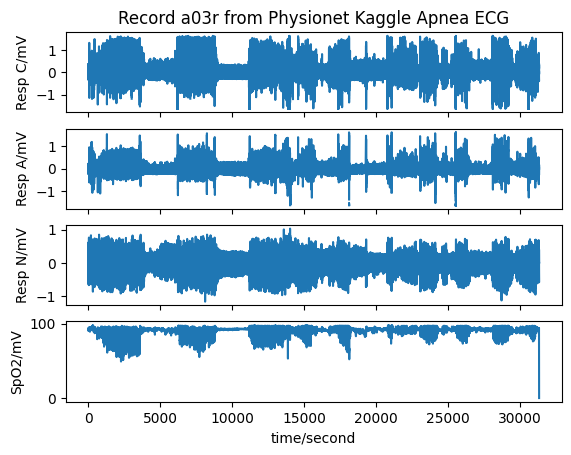

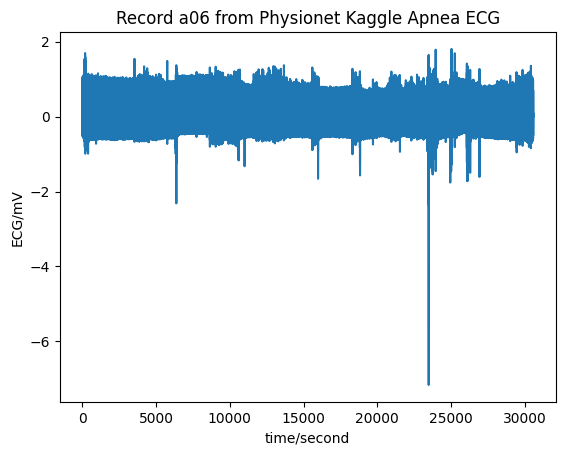

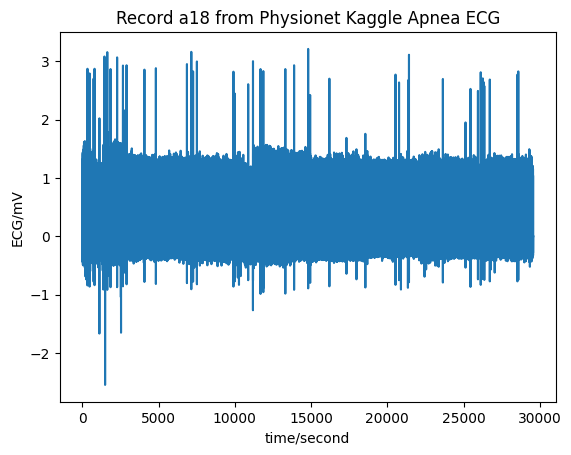

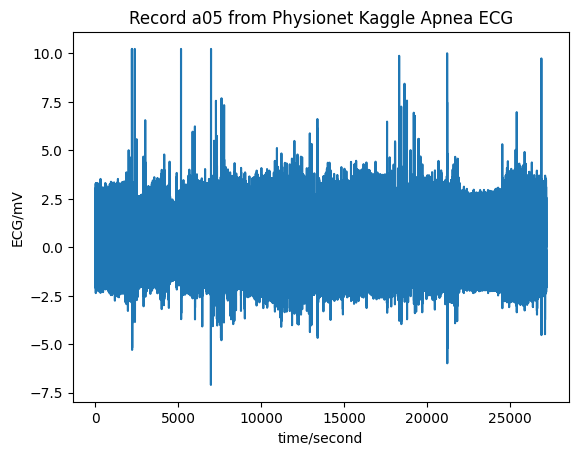

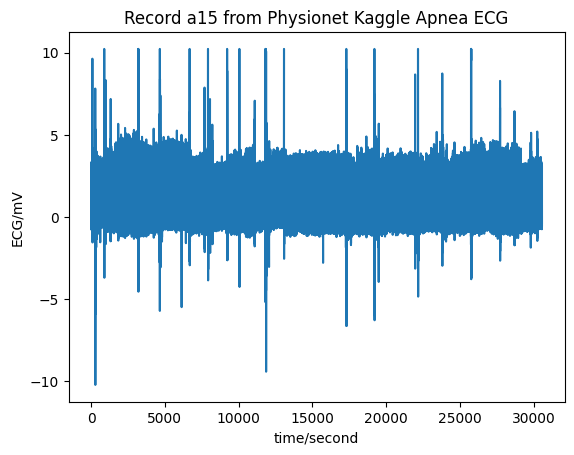

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0'

for dirname, _, filenames in os.walk(data_dir):
    for filename in filenames:
        if filename.endswith('.dat'):
            record_name = os.path.splitext(filename)[0]  # 파일명에서 확장자 제거

            record = wfdb.rdrecord(os.path.join(dirname, record_name))
            wfdb.plot_wfdb(record, title=f'Record {record_name} from Physionet Kaggle Apnea ECG')

In [ ]:
import struct

# 파일에서 심전도 데이터 읽기
def read_ecg_data(file):
    ecg_data = []
# 16비트 데이터를 signed short 형식으로 변환
    while True:
        raw_data = file.read(2)  # 2바이트(16비트) 데이터 읽기

        if not raw_data:
            break

        data_value = struct.unpack('<h', raw_data)[0]  # 16비트 데이터를 signed short로 변환
        ecg_data.append(data_value)

    return ecg_data


with open('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/a01.dat', 'rb') as file:
    ecg_data = read_ecg_data(file)

print(ecg_data[:10])
#'a01.dat' 파일에서 16비트 이진 데이터를 읽어와서 해당 데이터를 signed short로 변환하여 리스트로 저장한 후, 처음 10개의 값을 출력하는 예시입니다.

[-12, -13, -12, -15, -13, -14, -14, -18, -16, -19]


In [ ]:
import struct
import wfdb

# "rnn.dat" 파일에서 ECG 데이터 읽기
def read_ecg_data(file):
    ecg_data = []

    while True:
        raw_data = file.read(2)
        if not raw_data:
            break

        data_value = struct.unpack('<h', raw_data)[0]  # 16비트 데이터를 signed short로 변환
        ecg_data.append(data_value)

    return ecg_data

# .apn 파일에서 무호흡 유형 정보 읽기
def read_apn_data(file):
    apn_data = []

    while True:
        line = file.readline().strip()
        if not line:
            break

        apn_data.append(line.decode('latin1'))

    return apn_data

# "rnn.dat" 파일 읽기
with open('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/a01.dat', 'rb') as ecg_file:
    ecg_data = read_ecg_data(ecg_file)

# .apn 파일 읽기
with open('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/a01.apn', 'rb') as apn_file:
    apn_data = read_apn_data(apn_file)


In [ ]:
# ECG 데이터와 수면무호흡 유형 정보 합치기
combined_data = []

for index, apn_value in enumerate(apn_data):
    start_sample = index * 100  # 1초당 100개 샘플링이므로 인덱스로 변환
    end_sample = start_sample + 100

    ecg_segment = ecg_data[start_sample:end_sample]
    combined_data.append((ecg_segment, apn_value))


In [ ]:
 combined_data

[([-12,
   -13,
   -12,
   -15,
   -13,
   -14,
   -14,
   -18,
   -16,
   -19,
   -16,
   -19,
   -16,
   -19,
   -17,
   -18,
   -18,
   -20,
   -17,
   -21,
   -18,
   -9,
   1,
   3,
   9,
   31,
   28,
   9,
   1,
   -8,
   -17,
   -40,
   -39,
   -40,
   -40,
   -48,
   -26,
   68,
   231,
   294,
   -31,
   -165,
   -118,
   -70,
   -31,
   -34,
   -28,
   -31,
   -23,
   -25,
   -18,
   -19,
   -13,
   -11,
   -3,
   -1,
   7,
   9,
   18,
   22,
   30,
   36,
   41,
   45,
   46,
   44,
   47,
   46,
   40,
   34,
   24,
   15,
   8,
   4,
   1,
   -1,
   -1,
   -2,
   -3,
   -2,
   0,
   -1,
   -4,
   -4,
   -3,
   -5,
   -7,
   -9,
   -9,
   -12,
   -13,
   -14,
   -11,
   -12,
   -16,
   -15,
   -18,
   -13,
   -15,
   -16],
  '\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x00\x00p\x17\x00\x04\x00ì\x0

In [ ]:
import pandas as pd

# combined_data 리스트에서 데이터 추출
ecg_segments = [item[0] for item in combined_data]
apn_labels = [item[1] for item in combined_data]

# DataFrame 생성
data = {
    'ECG_Segment': ecg_segments,
    'APN_Label': apn_labels
}

df = pd.DataFrame(data)

# DataFrame 확인
print(df.head())

                                         ECG_Segment  \
0  [-12, -13, -12, -15, -13, -14, -14, -18, -16, ...   

                                           APN_Label  
0    ì  p  ì  p  ì  p  ì  p  ì  p  ì  ...  


In [ ]:
df

,ECG_Segment,APN_Label
0,"[-12, -13, -12, -15, -13, -14, -14, -18, -16, ...",  ì  p  ì  p  ì  p  ì  p  ì  p  ì  ...


In [ ]:
# https://github.com/pss1207/sleep_apnea/blob/master/pre_proc.py
import wfdb
import matplotlib.pyplot as plt
import numpy as np
# from hrv.filters import quotient, moving_median
from scipy import interpolate
from tqdm import tqdm
import pickle
import os
FS = 100.0

data_path = '/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/'
train_data_name = ['a02', 'a03', 'a04', 'a05',
             'a06', 'a07', 'a08', 'a09', 'a10',
             'a11', 'a12', 'a13', 'a14', 'a15',
             'a16', 'a17', 'a18', 'a19',
             'b02', 'b03', 'b04',
             'c02', 'c03', 'c04', 'c05',
             'c06', 'c07', 'c08', 'c09',
             ]
val_data_name = ['a01', 'b01', 'c01']
test_data_name = ['a20','b05','c10']
age = [51, 38, 54, 52, 58,
       63, 44, 51, 52, 58,
       58, 52, 51, 51, 60,
       44, 40, 52, 55, 58,
       44, 53, 53, 42, 52,
       31, 37, 39, 41, 28,
       28, 30, 42, 37, 27]
sex = [1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,
       0, 1, 1, 1, 1,
       1, 1, 1, 0, 0,
       0, 0, 1, 1, 1]


MARGIN = 10
FS_INTP = 4
MAX_HR = 300.0
MIN_HR = 20.0
MIN_RRI = 1.0 / (MAX_HR / 60.0) * 1000
MAX_RRI = 1.0 / (MIN_HR / 60.0) * 1000
train_input_array = []
train_label_array = []

for data_index in range(len(train_data_name)):
    print (train_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path,train_data_name[data_index]), 'apn').symbol)
    signals, fields = wfdb.rdsamp(os.path.join(data_path,train_data_name[data_index]))
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS # 60 seconds
        samp_to = samp_from + 60 * FS  # 60 seconds



a02


100%|██████████| 527/527 [00:00<00:00, 331543.15it/s]


a03


100%|██████████| 518/518 [00:00<00:00, 813117.32it/s]


a04


100%|██████████| 491/491 [00:00<00:00, 375050.68it/s]


a05


100%|██████████| 453/453 [00:00<00:00, 427354.86it/s]


a06


100%|██████████| 509/509 [00:00<00:00, 450686.24it/s]


a07


100%|██████████| 510/510 [00:00<00:00, 1149433.12it/s]


a08


100%|██████████| 500/500 [00:00<00:00, 901225.61it/s]


a09


100%|██████████| 494/494 [00:00<00:00, 780115.28it/s]


a10


100%|██████████| 516/516 [00:00<00:00, 990508.40it/s]


a11


100%|██████████| 465/465 [00:00<00:00, 829583.73it/s]


a12


100%|██████████| 576/576 [00:00<00:00, 336432.13it/s]


a13


100%|██████████| 494/494 [00:00<00:00, 911965.75it/s]


a14


100%|██████████| 508/508 [00:00<00:00, 920391.55it/s]


a15


100%|██████████| 509/509 [00:00<00:00, 245984.65it/s]


a16


100%|██████████| 481/481 [00:00<00:00, 746102.15it/s]


a17


100%|██████████| 484/484 [00:00<00:00, 978805.76it/s]


a18


100%|██████████| 488/488 [00:00<00:00, 946725.42it/s]


a19


100%|██████████| 501/501 [00:00<00:00, 474665.98it/s]


b02


100%|██████████| 516/516 [00:00<00:00, 1001972.62it/s]


b03


100%|██████████| 440/440 [00:00<00:00, 320175.88it/s]


b04


100%|██████████| 428/428 [00:00<00:00, 1005693.06it/s]


c02


100%|██████████| 501/501 [00:00<00:00, 932688.11it/s]


c03


100%|██████████| 453/453 [00:00<00:00, 222458.69it/s]


c04


100%|██████████| 481/481 [00:00<00:00, 353134.99it/s]


c05


100%|██████████| 465/465 [00:00<00:00, 820854.95it/s]


c06


100%|██████████| 467/467 [00:00<00:00, 579680.37it/s]


c07


100%|██████████| 428/428 [00:00<00:00, 424689.40it/s]


c08


100%|██████████| 512/512 [00:00<00:00, 826909.38it/s]


c09


100%|██████████| 467/467 [00:00<00:00, 492145.72it/s]


In [ ]:
pip install hrv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.7/55.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for spectrum: filename=spectrum-0.8.1-cp310-cp310-linux_x86_64.whl size=236593 sha256=f3be240390271e9fe73f452bf75bd3b3c4f16835389d84c7b0a529d3a0ecb415
  Stored in directory: /root/.cache/pip/wheels/e7/5a/09/ffc6afdf8a5a6f58e9851292108df32bb11374e11b8705cabd
  Created wheel for easydev: filename=easydev-0.12.1-py3-none-any.whl size=64212 sha256=3533a63bb94e2719f3ad8bc07c3cdcca8b6d387a5f9bfda258d491af45a891c1
  Stored in directory: /root/.cache/pip/wheels/c5/a3/df/e8e19f6f1674c2b0574ccc1a156292b599709eaa4feeea0fcf
Successfully built spectrum easydev


In [ ]:
pip install hrv-analysis

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!sudo apt-get update
!sudo apt-get install python3.9

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,235 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,103 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [49.9 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 https://developer.downlo

In [ ]:
!python --version

Python 3.10.12


In [ ]:
  !wget https://www.python.org/ftp/python/3.9/Python-3.9.tgz
  !tar xvfz Python-3.9.tgz
  !Python-3.9/configure
  !make
  !sudo make install

--2023-08-10 05:47:04--  https://www.python.org/ftp/python/3.9/Python-3.9.tgz
Resolving www.python.org (www.python.org)... 146.75.36.223, 2a04:4e42:77::223
Connecting to www.python.org (www.python.org)|146.75.36.223|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-08-10 05:47:04 ERROR 404: Not Found.

tar (child): Python-3.9.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
/bin/bash: line 1: Python-3.9/configure: No such file or directory
make: *** No targets specified and no makefile found.  Stop.
make: *** No rule to make target 'install'.  Stop.


In [ ]:
  !python --version

Python 3.10.12


In [ ]:
pip install Tensorflow

In [ ]:
!apt-get install python3.9
!ln -sf /usr/bin/python3.9 /usr/bin/python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3.9 is already the newest version (3.9.17-1+jammy1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.


In [ ]:
  !python --version

Python 3.10.12


#### wfdb 라이브러리를 사용하여 데이터를 읽어오고,이어서 심박 주기 추출에 필요한 전처리 단계를 수행행, qrs_ann 변수를 사용해서 심박 주기의 기본 위치를 가져오고 , apn_ann 변수를 사용해서 양성 또는 음성 레이블을 가져와라 이자식아
#### R-peak 위치와 심박주기 (RRI)를 추출하고
#### 데이터를 저장하는데 RRI 데이터와 해당 레이블, 그리고 나이,성별을 저장하는 작업을 수행 이후 각 데이터를 pickle 파일 형식으로 저장

In [ ]:
from hrvanalysis import get_time_domain_features

 # nn_intervals_list contains integer values of NN-interval
nn_intervals_list = [1000, 1050, 1020, 1080, ..., 1100, 1110, 1060]

time_domain_features = get_time_domain_features(nn_intervals_list)

TypeError: ignored

In [ ]:
#https://github.com/pss1207/sleep_apnea/blob/master/pre_proc.py
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values
from scipy import interpolate
from tqdm import tqdm
import pickle
import os
FS = 100.0

# From https://github.com/rhenanbartels/hrv/blob/develop/hrv/classical.py
def create_time_info(rri):
    rri_time = np.cumsum(rri) / 1000.0  # make it seconds
    return rri_time - rri_time[0]   # force it to start at zero

def create_interp_time(rri, fs):
    time_rri = create_time_info(rri)
    return np.arange(0, time_rri[-1], 1 / float(fs))

def interp_cubic_spline(rri, fs):
    time_rri = create_time_info(rri)
    time_rri_interp = create_interp_time(rri, fs)
    tck = interpolate.splrep(time_rri, rri, s=0)
    rri_interp = interpolate.splev(time_rri_interp, tck, der=0)
    return time_rri_interp, rri_interp

def interp_cubic_spline_qrs(qrs_index, qrs_amp, fs):
    time_qrs = qrs_index / float(FS)
    time_qrs = time_qrs - time_qrs[0]
    time_qrs_interp = np.arange(0, time_qrs[-1], 1/float(fs))
    tck = interpolate.splrep(time_qrs, qrs_amp, s=0)
    qrs_interp = interpolate.splev(time_qrs_interp, tck, der=0)
    return time_qrs_interp, qrs_interp

data_path = '/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/'
train_data_name = ['a02', 'a03', 'a04', 'a05',
             'a06', 'a07', 'a08', 'a09', 'a10',
             'a11', 'a12', 'a13', 'a14', 'a15',
             'a16', 'a17', 'a18', 'a19',
             'b02', 'b03', 'b04',
             'c02', 'c03', 'c04', 'c05',
             'c06', 'c07', 'c08', 'c09',
             ]
val_data_name = ['a01', 'b01', 'c01']
test_data_name = ['a20','b05','c10']
age = [51, 38, 54, 52, 58,
       63, 44, 51, 52, 58,
       58, 52, 51, 51, 60,
       44, 40, 52, 55, 58,
       44, 53, 53, 42, 52,
       31, 37, 39, 41, 28,
       28, 30, 42, 37, 27]
sex = [1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,
       1, 1, 1, 1, 1,
       0, 1, 1, 1, 1,
       1, 1, 1, 0, 0,
       0, 0, 1, 1, 1]


def get_qrs_amp(ecg, qrs):
    interval = int(FS * 0.250)
    qrs_amp = []
    for index in range(len(qrs)):
        curr_qrs = qrs[index]
        amp = np.max(ecg[curr_qrs-interval:curr_qrs+interval])
        qrs_amp.append(amp)

    return qrs_amp

MARGIN = 10
FS_INTP = 4
MAX_HR = 300.0
MIN_HR = 20.0
MIN_RRI = 1.0 / (MAX_HR / 60.0) * 1000
MAX_RRI = 1.0 / (MIN_HR / 60.0) * 1000
train_input_array = []
train_label_array = []

for data_index in range(len(train_data_name)):
    print (train_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path,train_data_name[data_index]), 'apn').symbol)
    signals, fields = wfdb.rdsamp(os.path.join(data_path,train_data_name[data_index]))
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS # 60 seconds
        samp_to = samp_from + 60 * FS  # 60 seconds

        qrs_ann = wfdb.rdann(data_path + train_data_name[data_index], 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample
        apn_ann = wfdb.rdann(data_path + train_data_name[data_index], 'apn', sampfrom=samp_from, sampto=samp_to-1).symbol

        qrs_amp = get_qrs_amp(signals, qrs_ann)

        rri = np.diff(qrs_ann)
        rri_ms = rri.astype('float') / FS * 1000.0
        try:
            rri_filt = moving_median(rri_ms)

            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)
                qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]
                qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]
                #time_intp = time_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]

                if len(rri_intp) != (FS_INTP * 60):
                    skip = 1
                else:
                    skip = 0

                if skip == 0:
                    rri_intp = rri_intp - np.mean(rri_intp)
                    qrs_intp = qrs_intp - np.mean(qrs_intp)
                    if apn_ann[0] == 'N': # Normal
                        label = 0.0
                    elif apn_ann[0] == 'A': # Apnea
                        label = 1.0
                    else:
                        label = 2.0

                    train_input_array.append([rri_intp, qrs_intp, age[data_index], sex[data_index]])
                    train_label_array.append(label)
        except:
            hrv_module_error = 1
with open('train_input.pickle','wb') as f:
    pickle.dump(train_input_array, f)
with open('train_label.pickle','wb') as f:
    pickle.dump(train_label_array, f)


val_input_array = []
val_label_array = []
for data_index in range(len(val_data_name)):
    print (val_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path,val_data_name[data_index]), 'apn').symbol)
    signals, fields = wfdb.rdsamp(os.path.join(data_path,val_data_name[data_index]))
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS # 60 seconds
        samp_to = samp_from + 60 * FS  # 60 seconds

        qrs_ann = wfdb.rdann(data_path + val_data_name[data_index], 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample
        apn_ann = wfdb.rdann(data_path + val_data_name[data_index], 'apn', sampfrom=samp_from, sampto=samp_to-1).symbol

        qrs_amp = get_qrs_amp(signals, qrs_ann)

        rri = np.diff(qrs_ann)
        rri_ms = rri.astype('float') / FS * 1000.0
        try:
            rri_filt = moving_median(rri_ms)

            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)
                qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]
                qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]
                #time_intp = time_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]

                if len(rri_intp) != (FS_INTP * 60):
                    skip = 1
                else:
                    skip = 0

                if skip == 0:
                    rri_intp = rri_intp - np.mean(rri_intp)
                    qrs_intp = qrs_intp - np.mean(qrs_intp)
                    if apn_ann[0] == 'N': # Normal
                        label = 0.0
                    elif apn_ann[0] == 'A': # Apnea
                        label = 1.0
                    else:
                        label = 2.0

                    val_input_array.append([rri_intp, qrs_intp, age[data_index], sex[data_index]])
                    val_label_array.append(label)
        except:
            hrv_module_error = 1

with open('val_input.pickle','wb') as f:
    pickle.dump(val_input_array, f)
with open('val_label.pickle','wb') as f:
    pickle.dump(val_label_array, f)

test_input_array = []
test_label_array = []
for data_index in range(len(test_data_name)):
    print (test_data_name[data_index])
    win_num = len(wfdb.rdann(os.path.join(data_path,test_data_name[data_index]), 'apn').symbol)
    signals, fields = wfdb.rdsamp(os.path.join(data_path,test_data_name[data_index]))
    for index in tqdm(range(1, win_num)):
        samp_from = index * 60 * FS # 60 seconds
        samp_to = samp_from + 60 * FS  # 60 seconds

        qrs_ann = wfdb.rdann(data_path + test_data_name[data_index], 'qrs', sampfrom=samp_from - (MARGIN*100), sampto=samp_to + (MARGIN*100)).sample
        apn_ann = wfdb.rdann(data_path + test_data_name[data_index], 'apn', sampfrom=samp_from, sampto=samp_to-1).symbol

        qrs_amp = get_qrs_amp(signals, qrs_ann)

        rri = np.diff(qrs_ann)
        rri_ms = rri.astype('float') / FS * 1000.0
        try:
            rri_filt = moving_median(rri_ms)

            if len(rri_filt) > 5 and (np.min(rri_filt) >= MIN_RRI and np.max(rri_filt) <= MAX_RRI):
                time_intp, rri_intp = interp_cubic_spline(rri_filt, FS_INTP)
                qrs_time_intp, qrs_intp = interp_cubic_spline_qrs(qrs_ann, qrs_amp, FS_INTP)
                rri_intp = rri_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]
                qrs_intp = qrs_intp[(qrs_time_intp >= MARGIN) & (qrs_time_intp < (60 + MARGIN))]
                #time_intp = time_intp[(time_intp >= MARGIN) & (time_intp < (60+MARGIN))]

                if len(rri_intp) != (FS_INTP * 60):
                    skip = 1
                else:
                    skip = 0

                if skip == 0:
                    rri_intp = rri_intp - np.mean(rri_intp)
                    qrs_intp = qrs_intp - np.mean(qrs_intp)
                    if apn_ann[0] == 'N': # Normal
                        label = 0.0
                    elif apn_ann[0] == 'A': # Apnea
                        label = 1.0
                    else:
                        label = 2.0

                    test_input_array.append([rri_intp, qrs_intp, age[data_index], sex[data_index]])
                    test_label_array.append(label)
        except:
            hrv_module_error = 1

with open('test_input.pickle','wb') as f:
    pickle.dump(test_input_array, f)
with open('test_label.pickle','wb') as f:
    pickle.dump(test_label_array, f)

a02


100%|██████████| 527/527 [02:11<00:00,  4.01it/s]


a03


100%|██████████| 518/518 [02:07<00:00,  4.06it/s]


a04


100%|██████████| 491/491 [01:52<00:00,  4.37it/s]


a05


100%|██████████| 453/453 [01:37<00:00,  4.66it/s]


a06


100%|██████████| 509/509 [01:44<00:00,  4.87it/s]


a07


 79%|███████▉  | 405/510 [01:27<00:22,  4.63it/s]


KeyboardInterrupt: ignored


#### Convert raw ecg data to pickle files
#### ecg, r_peaks, and atfs are reshaped into segments with 1-min long to pair with apn labels
#### Removing first several minutes of problematic recording (usually when ecg is not recording or with abnormal signals)

In [ ]:
pip install biosppy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 951.8 kB/s eta 0:00:00


#### 파일에서 ecg데이터를 로드하고 처리
#### 신호를 필터링하고 R-피크 (QRS 복합체의 최고점)를 감지하며 RR 간격 (RRI) 및 심박수 (HR)와 같은 관련 기능을 계산합니다
#### R-피크와 심박수의 품질을 확인하고 잘못된 세그먼트를 제거합니다.
#### RRI와 진폭 신호를 포함하는 특징 벡터 X 및 레이블 y, 그리고 처리된 데이터를 위한 레코딩 이름 목록을 생성합니다.
#### RRI와 진폭 신호를 포함하는 특징 벡터 X 및 레이블 y, 그리고 처리된 데이터를 위한 레코딩 이름 목록을 생성합니다.



In [ ]:
import pickle
import sys
from concurrent.futures import ProcessPoolExecutor, as_completed

import biosppy.signals.tools as st
import numpy as np
import os
import wfdb
from biosppy.signals.ecg import correct_rpeaks, hamilton_segmenter
from scipy.signal import medfilt
from tqdm import tqdm

# PhysioNet Apnea-ECG dataset
# url: https://physionet.org/physiobank/database/apnea-ecg/
base_dir = '/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0'

fs = 100
sample = fs * 60  # 1 min's sample points

before = 2  # forward interval (min)
after = 2  # backward interval (min)
hr_min = 20
hr_max = 300

num_worker = 35


def worker(name, labels):
    X = []
    y = []
    groups = []
    signals = wfdb.rdrecord(os.path.join(base_dir, name), channels=[0]).p_signal[:, 0]
    for j in tqdm(range(len(labels)), desc=name, file=sys.stdout):
        if j < before or \
                (j + 1 + after) > len(signals) / float(sample):
            continue
        signal = signals[int((j - before) * sample):int((j + 1 + after) * sample)]
        signal, _, _ = st.filter_signal(signal, ftype='FIR', band='bandpass', order=int(0.3 * fs),
                                        frequency=[3, 45], sampling_rate=fs)
        # Find R peaks
        rpeaks, = hamilton_segmenter(signal, sampling_rate=fs)
        rpeaks, = correct_rpeaks(signal, rpeaks=rpeaks, sampling_rate=fs, tol=0.1)
        if len(rpeaks) / (1 + after + before) < 40 or \
                len(rpeaks) / (1 + after + before) > 200:  # Remove abnormal R peaks signal
            continue
        # Extract RRI, Ampl signal
        rri_tm, rri_signal = rpeaks[1:] / float(fs), np.diff(rpeaks) / float(fs)
        rri_signal = medfilt(rri_signal, kernel_size=3)
        ampl_tm, ampl_siganl = rpeaks / float(fs), signal[rpeaks]
        hr = 60 / rri_signal
        # Remove physiologically impossible HR signal
        if np.all(np.logical_and(hr >= hr_min, hr <= hr_max)):
            # Save extracted signal
            X.append([(rri_tm, rri_signal), (ampl_tm, ampl_siganl)])
            y.append(0. if labels[j] == 'N' else 1.)
            groups.append(name)
    return X, y, groups


if __name__ == "__main__":
    apnea_ecg = {}

    names = [
        "a01", "a02", "a03", "a04", "a05", "a06", "a07", "a08", "a09", "a10",
        "a11", "a12", "a13", "a14", "a15", "a16", "a17", "a18", "a19", "a20",
        "b01", "b02", "b03", "b04", "b05",
        "c01", "c02", "c03", "c04", "c05", "c06", "c07", "c08", "c09", "c10"
    ]

    o_train = []
    y_train = []
    groups_train = []
    print('Training...')
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = wfdb.rdann(os.path.join(base_dir, names[i]), extension="apn").symbol
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_train.extend(X)
            y_train.extend(y)
            groups_train.extend(groups)

    print()

    answers = {}
    with open('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0', "r") as f:
        for answer in f.read().split("\n\n"):
            answers[answer[:3]] = list("".join(answer.split()[2::2]))

    names = [
        "x01", "x02", "x03", "x04", "x05", "x06", "x07", "x08", "x09", "x10",
        "x11", "x12", "x13", "x14", "x15", "x16", "x17", "x18", "x19", "x20",
        "x21", "x22", "x23", "x24", "x25", "x26", "x27", "x28", "x29", "x30",
        "x31", "x32", "x33", "x34", "x35"
    ]

    o_test = []
    y_test = []
    groups_test = []
    print("Testing...")
    with ProcessPoolExecutor(max_workers=num_worker) as executor:
        task_list = []
        for i in range(len(names)):
            labels = answers[names[i]]
            task_list.append(executor.submit(worker, names[i], labels))

        for task in as_completed(task_list):
            X, y, groups = task.result()
            o_test.extend(X)
            y_test.extend(y)
            groups_test.extend(groups)

    apnea_ecg = dict(o_train=o_train, y_train=y_train, groups_train=groups_train, o_test=o_test, y_test=y_test,
                     groups_test=groups_test) #추출된 특징 및 레이블은 리스트 (o_train, y_train, groups_train, o_test, y_test, groups_test)에 저장됩니다.
    with open(os.path.join(base_dir, "apnea-ecg.pkl"), "wb") as f:
        pickle.dump(apnea_ecg, f, protocol=2)

    print("\nok!") # ecg신호에서 특징을 추출학 이를 pickle파일에 저장

Training...
a17: 100%|██████████| 485/485 [59:24<00:00,  7.35s/it]



IsADirectoryError: ignored

In [ ]:
train_full = [f'a{i:02d}' for i in range(
    1, 21)] + [f'b{i:02d}' for i in range(1, 6)] + [f'c{i:02d}' for i in range(1, 11)]
train_test = ['a01']
data_folder = '../data_archive/training'
ratio_lb, ratio_ub = 0.6, 2

In [ ]:
ecgs_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/list', header=None, names=['id'])
# add filepaths so we can retrieve the files later on
ecgs_df['filepath'] = ecgs_df['id'].apply(lambda x: str("/content/drive/MyDrive/Colab Notebooks/apnea-ecg-database-1.0.0/" + x) )
# divide the dataset into train and test dataset as per instrucctions in the data set
ecgs_df['dataset'] = ecgs_df['id'].apply(lambda x: "test" if 'x' in x else "train")

In [ ]:
ecgs_df.head()

In [ ]:
import numpy as np
import scipy.signal  as sgn

In [ ]:
# https://www.kaggle.com/code/paulopinheiro/apnea-ecg/notebook
def load_ecg(file):
    # load the ecg

    # load the ecg
    record = wfdb.rdrecord(file)

    # load the annotation
    annotation = wfdb.rdann(file, extension="apn")

    # extract the signal
    p_signal = record.p_signal

    # verify frequency is 100
    assert record.fs == 100, 'sample freq is not 100'

    # extract symbols and annotation index
    atr_sym = annotation.symbol
    atr_sample = annotation.sample

    return p_signal, atr_sym, atr_sample

In [ ]:
def build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y

    num_rows = len(df_ann)

    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []

    # keep track of rows
    max_row = 0

    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):

        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]

    return X, Y, sym

In [ ]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output:
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)

    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []

    # list to keep track of number of beats across patients
    max_rows = []

    for pt in pts:
        file = pt

        p_signal, atr_sym, atr_sample = load_ecg(file)

        # grab the first signal
        p_signal = p_signal[:,0]

        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})

        X, Y, sym = build_XY(p_signal, df_ann, num_cols, abnormal, num_sec, fs)

        sym_all = sym_all +sym

        max_rows.append(X.shape[0])

        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)

    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]

    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'

    return X_all, Y_all, sym_all

In [ ]:
abnormal = ['A']

In [ ]:
pts = ecgs_df[ecgs_df['dataset']=='train']

In [ ]:
x_train, y_train, sym_all = make_dataset(pts['filepath'], num_sec=15, fs=100, abnormal=abnormal)

In [ ]:
pts_text = ecgs_df[ecgs_df['dataset']=='test']

In [ ]:
x_test, y_test, sym_all_test = make_dataset(pts_text['filepath'], num_sec=15, fs=100, abnormal=abnormal) #까지 이해

In [ ]:
import matplotlib.pyplot as plt

def plot_ecgs(ecg, true_labels, class_names, start = 0 ):
    plt.figure(figsize=[12, 18])
    rows = 8
    columns = 2
    fig, ax = plt.subplots(rows, columns, figsize=(15, 15))
    index = start
    for i in range(rows):
        for j in range(columns):
            ax[i, j].plot(ecg[index])
            index = index+1
            #ax[i, j].set_ylim(ecg[i].min()-0.05,ecg[i].max()+0.05)
            ax[i, j].set_xlabel('time index')
            ax[i, j].set_ylabel('ECG signal')
            ax[i, j].set_title(class_names[int(true_labels[index])])

    plt.tight_layout()# 이해

In [ ]:
plot_ecgs(x_test, y_test, class_names = ['Normal','Apnea'], start=400)

In [ ]:
values, counts = np.unique(sym_all, return_counts=True)

In [ ]:
values, counts

In [ ]:
values, counts = np.unique(sym_all_test, return_counts=True)

In [ ]:
values, counts

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

#x_train, x_test, y_train, y_test = train_test_split(X_all, Y_all, train_size = 0.8)

In [ ]:
values, counts = np.unique(y_test, return_counts=True)

In [ ]:
values, counts

In [ ]:
plt.figure(figsize=(5,5))
plt.pie(counts, labels=['0','1'], colors=['red','green'], autopct='%1.1f%%')
plt.show()

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [ ]:
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
x_train.shape

In [ ]:
import keras
from keras import models
from keras import layers

model = models.Sequential()

model.add(layers.Conv1D(64, 32, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=4, strides=2, padding="same"))

model.add(layers.Conv1D(48, 32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=3, strides=2, padding="same"))

model.add(layers.Conv1D(48, 24, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Conv1D(32, 16, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=2, strides=2, padding="same"))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

print(model.summary())

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 10, batch_size = 512)